In [1]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
#!pip install tensorflow==2.0.0-beta0


tf.enable_eager_execution()

# !pip install -q tensorflow-datasets

1.15.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)




array([1, 1, 1, ..., 1, 1, 1])

In [9]:
for s,l in train_data:
  print(s.numpy())
  break

b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really

In [12]:
training_sentences[0:3]

['b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\\xc3\\xa9, but he was a people\'s writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It\'s not 

In [0]:
vocab_size = 20000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"#out of vocabulary


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index



sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'<UNK>') for i in text])#<UNK> in padded means it reached max dictionary size

print(decode_review(padded[15]))#this is the padded one with max 120 size of words
print(training_sentences[15])#original sentence

<OOV> down to watch the 14th season of the bachelor on the wings of love i knew i would be in for an interesting time i had watched some of the previous seasons of the bachelor in passing watching an episode or two and missing the next three or so i find that the bachelor is often appealing and intriguing though its quality and morality are often lacking br br on the wings of love details the journey taken by jake a 31 year old commercial pilot from dallas texas to find true love as true a love as one can find in a season long reality drama dating show jake meets 25 beautiful girls from all over the country
b'Sitting down to watch the 14th season of the Bachelor ("On the Wings of Love"), I knew I would be in for an "interesting" time. I had watched some of the previous seasons of the Bachelor in passing; watching an episode or two and missing the next three or so. I find that the Bachelor is often appealing and intriguing, though its quality and morality are often lacking.<br /><br />"

In [29]:
from keras.utils import plot_model
import matplotlib.pyplot as plt



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt=tf.keras.optimizers.Adam(learning_rate=0.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
    )
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
tf.keras.metrics.AUC(),tf.keras.metrics.TrueNegatives()
])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           320000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                96050     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 416,101
Trainable params: 416,101
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_epochs = 5
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 12s 474us/sample - loss: 0.4670 - acc: 0.7586 - precision_3: 0.7605 - recall_3: 0.7550 - auc_3: 0.8545 - true_negatives_3: 9528.0000 - val_loss: 0.3554 - val_acc: 0.8436 - val_precision_3: 0.8350 - val_recall_3: 0.8563 - val_auc_3: 0.9222 - val_true_negatives_3: 10385.0000
Epoch 2/5
25000/25000 [==============================] - 11s 436us/sample - loss: 0.1724 - acc: 0.9377 - precision_3: 0.9359 - recall_3: 0.9398 - auc_3: 0.9811 - true_negatives_3: 11695.0000 - val_loss: 0.4439 - val_acc: 0.8190 - val_precision_3: 0.8319 - val_recall_3: 0.7994 - val_auc_3: 0.9001 - val_true_negatives_3: 10481.0000
Epoch 3/5
25000/25000 [==============================] - 11s 439us/sample - loss: 0.0267 - acc: 0.9938 - precision_3: 0.9938 - recall_3: 0.9938 - auc_3: 0.9994 - true_negatives_3: 12422.0000 - val_loss: 0.5975 - val_acc: 0.8146 - val_precision_3: 0.8051 - val_recall_3: 0.8302 - val_auc_

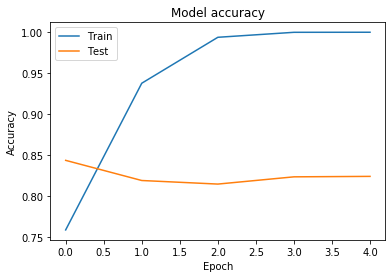

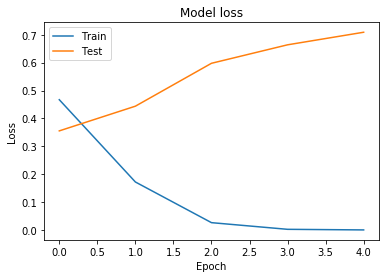

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Yes it seems to be overfitting but we have a good accuracy on validation

In [33]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(20000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

#now you can plot your embeddings on https://projector.tensorflow.org/